# Calculate mean_average_precision(mAP)

## Read Weight Yolo

In [ ]:
import os
import scipy.io
import scipy.misc
import numpy as np  
import pandas as pd
import struct
import cv2
from numpy import expand_dims
import tensorflow as tf
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.models import load_model, Model
from keras.layers.merge import add, concatenate
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle

%matplotlib inline

In [ ]:

from google.colab import drive

drive.mount('/content/drive/')
!nvidia-smi

Mounted at /content/drive/
Sat Jan 30 10:46:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                             

In [ ]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

In [ ]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

In [ ]:
from keras.layers import ( Conv2D, Add, ZeroPadding2D, UpSampling2D, Concatenate, MaxPooling2D,)

from functools import reduce
from keras.regularizers import l2

model = make_yolov3_model()
model.load_weights('/content/drive/MyDrive/NewYolov3onlyTrain/1train14.h5')

In [ ]:
input_w, input_h = 416, 416
net_h, net_w = 416, 416
obj_thresh, nms_thresh = 0.2, 0.3
address_test="/content/drive/My Drive/widerface/WIDER_val/images"
labels = ["face"]


In [ ]:
from numpy import expand_dims
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [ ]:

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3 
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [ ]:
#decode_netout() that will take each one of the NumPy arrays, one at a time, 
#and decode the candidate bounding boxes and class predictions
def decode_netout(netout, anchors, obj_thresh,  net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]
            
            if(objectness.all() <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height 
            if w>1: 
              print('w=',w)
            if h>1:
              print('h=',h)
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes

In [ ]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin ) * image_w)
        boxes[i].xmax = int((boxes[i].xmax )  * image_w)
        boxes[i].ymin = int((boxes[i].ymin )  * image_h)
        boxes[i].ymax = int((boxes[i].ymax )  * image_h)
 
      

In [ ]:
from matplotlib.patches import Rectangle
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    list_bb=[]
    list_pr=[]
    # load the image
    data = plt.imread(filename)
  # data=cv2.resize(data,(416,416))
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        list_1bb=[]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        #print(x1,y1,y2,x2)
        list_1bb.append(x1)
        list_1bb.append(y1)
        list_1bb.append(x2)
        list_1bb.append(y2)

        list_bb.append(list_1bb)
        list_pr.append(float(format(v_scores[i]/100, '.2f')))
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % ('face', v_scores[i])
        #print(label)
        #plt.text(x1, y1, label, color='red')
        
        plt.savefig('books_read.png',bbox_inches='tight',dpi=200)
    # show the plot
  #  plt.show()
    return list_bb,list_pr

In [ ]:


def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(1):
            # check if the threshold for this label is high enough
            
            if box.classes[i] > thresh:
                v_boxes.append(box)
                #print(i,labels[i])
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

In [ ]:
from scipy.io import loadmat
import pandas as pd
data=loadmat('/content/wider_easy_val.mat')
data.keys()
data_name = pd.DataFrame(data['file_list'])[0]
data_bb = pd.DataFrame(data['face_bbx_list'])[0]
dataname_file = data['event_list']
data_invalid = data['invalid_label_list']

dict_test_map={}
for i in range(61):
  lenght=len(data_name[i])
  for j in range(lenght):# every image
    list_box=[]
    name_image = dataname_file[i][0][0]+"/"+data_name[i][j][0][0]

    if 40<=int(dataname_file[i][0][0].split('-')[0])<=59 :# number of class for easy-medium-hard
         array_invalid=data_invalid[i][0]
         for k in range(len(array_invalid[j][0] )):#every box
            if array_invalid[j][0][k] == 0:
              width=data_bb[i][j][0][k][2]
              height=data_bb[i][j][0][k][3]
              if width>0 and height>0:
                  list_box.append(data_bb[i][j][0][k])
              else:
                print(name_image)
                
         if len(list_box) != 0:
            dict_test_map[name_image]=list_box
          #  print(dataname_file[i][0][0].split('-')[0])

len(dict_test_map.keys())
import numpy as np
list_name_imag=dict_test_map.keys()
key_list=[]
for key in dict_test_map.keys(): 
        key_list.append(key) 

50--Celebration_Or_Party/50_Celebration_Or_Party_houseparty_50_715


In [ ]:
len(key_list)

952

In [ ]:
listInfoImage=[]
listInfoImageGT=[]
input_w, input_h = 416, 416


# define the anchors
anchors = [[116, 90, 156, 198, 373, 326], [30, 61, 62, 45, 59, 119] ,[10, 13, 16, 30, 33, 23] ]
# define the probability threshold for detected objects
class_threshold = 0.25

for index in range(len(key_list)):
        
      name=key_list[index]

      photo_filename =address_test+"/"+name+".jpg"

      image, image_w, image_h = load_image_pixels(photo_filename, (net_w, net_w))

      listInfoImageGT.append(np.array((image_w,image_h,dict_test_map[name])))
      

      # make prediction
      yolos = model.predict(image)
    
      boxes = list()

      for i in range(len(yolos)):
              # decode the output of the network
          boxes += decode_netout(yolos[i][0], anchors[i], obj_thresh,  net_h, net_w)

          # correct the sizes of the bounding boxes
      correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

      # suppress non-maximal boxes
      do_nms(boxes, nms_thresh)

      # get the details of the detected objects
      v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
      # summarize what we found
  

      list_bb,list_pr=draw_boxes(photo_filename, v_boxes, v_labels, v_scores)
      listInfoImage.append((image_w,image_h,list_bb,list_pr))
      

In [ ]:

def gtconvert(listInfoImage):
  for i in range(len(listInfoImage)):
    for j in range(len(listInfoImage[i][2])):
      listInfoImage[i][2][j][2]=listInfoImage[i][2][j][2]+listInfoImage[i][2][j][0]
      listInfoImage[i][2][j][3]=listInfoImage[i][2][j][3]+listInfoImage[i][2][j][1]
      
  return listInfoImage

In [ ]:
listInfoImageGT=gtconvert(listInfoImageGT)

In [ ]:
  
from enum import Enum

import cv2


class MethodAveragePrecision(Enum):
    """
    Class representing if the coordinates are relative to the
    image size or are absolute values.
        Developed by: Rafael Padilla
        Last modification: Apr 28 2018
    """
    EveryPointInterpolation = 1
    ElevenPointInterpolation = 2

class CoordinatesType(Enum):
    """
    Class representing if the coordinates are relative to the
    image size or are absolute values.
        Developed by: Rafael Padilla
        Last modification: Apr 28 2018
    """
    Relative = 1
    Absolute = 2


class BBType(Enum):
    """
    Class representing if the bounding box is groundtruth or not.
        Developed by: Rafael Padilla
        Last modification: May 24 2018
    """
    GroundTruth = 1
    Detected = 2


class BBFormat(Enum):
    """
    Class representing the format of a bounding box.
    It can be (X,Y,width,height) => XYWH
    or (X1,Y1,X2,Y2) => XYX2Y2
        Developed by: Rafael Padilla
        Last modification: May 24 2018
    """
    XYWH = 1
    XYX2Y2 = 2


# size => (width, height) of the image
# box => (X1, X2, Y1, Y2) of the bounding box
def convertToRelativeValues(size, box):
    dw = 1. / (size[0])
    dh = 1. / (size[1])
    cx = (box[1] + box[0]) / 2.0
    cy = (box[3] + box[2]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = cx * dw
    y = cy * dh
    w = w * dw
    h = h * dh
    # x,y => (bounding_box_center)/width_of_the_image
    # w => bounding_box_width / width_of_the_image
    # h => bounding_box_height / height_of_the_image
    return (x, y, w, h)


# size => (width, height) of the image
# box => (centerX, centerY, w, h) of the bounding box relative to the image
def convertToAbsoluteValues(size, box):
    # w_box = round(size[0] * box[2])
    # h_box = round(size[1] * box[3])
    xIn = round(((2 * float(box[0]) - float(box[2])) * size[0] / 2))
    yIn = round(((2 * float(box[1]) - float(box[3])) * size[1] / 2))
    xEnd = xIn + round(float(box[2]) * size[0])
    yEnd = yIn + round(float(box[3]) * size[1])
    if xIn < 0:
        xIn = 0
    if yIn < 0:
        yIn = 0
    if xEnd >= size[0]:
        xEnd = size[0] - 1
    if yEnd >= size[1]:
        yEnd = size[1] - 1
    return (xIn, yIn, xEnd, yEnd)


def add_bb_into_image(image, bb, color=(255, 0, 0), thickness=2, label=None):
    r = int(color[0])
    g = int(color[1])
    b = int(color[2])

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    fontThickness = 1

    x1, y1, x2, y2 = bb.getAbsoluteBoundingBox(BBFormat.XYX2Y2)
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)
    cv2.rectangle(image, (x1, y1), (x2, y2), (b, g, r), thickness)
    # Add label
    if label is not None:
        # Get size of the text box
        (tw, th) = cv2.getTextSize(label, font, fontScale, fontThickness)[0]
        # Top-left coord of the textbox
        (xin_bb, yin_bb) = (x1 + thickness, y1 - th + int(12.5 * fontScale))
        # Checking position of the text top-left (outside or inside the bb)
        if yin_bb - th <= 0:  # if outside the image
            yin_bb = y1 + th  # put it inside the bb
        r_Xin = x1 - int(thickness / 2)
        r_Yin = y1 - th - int(thickness / 2)
        # Draw filled rectangle to put the text in it
        cv2.rectangle(image, (r_Xin, r_Yin - thickness),
                      (r_Xin + tw + thickness * 3, r_Yin + th + int(12.5 * fontScale)), (b, g, r),
                      -1)
        cv2.putText(image, label, (xin_bb, yin_bb), font, fontScale, (0, 0, 0), fontThickness,
                    cv2.LINE_AA)
    return image


In [ ]:

class BoundingBoxes:
    def __init__(self):
        self._boundingBoxes = []

    def addBoundingBox(self, bb):
        self._boundingBoxes.append(bb)

    def removeBoundingBox(self, _boundingBox):
        for d in self._boundingBoxes:
            if BoundingBox.compare(d, _boundingBox):
                del self._boundingBoxes[d]
                return

    def removeAllBoundingBoxes(self):
        self._boundingBoxes = []

    def getBoundingBoxes(self):
        return self._boundingBoxes

    def getBoundingBoxByClass(self, classId):
        boundingBoxes = []
        for d in self._boundingBoxes:
            if d.getClassId() == classId:  # get only specified bounding box type
                boundingBoxes.append(d)
        return boundingBoxes

    def getClasses(self):
        classes = []
        for d in self._boundingBoxes:
            c = d.getClassId()
            if c not in classes:
                classes.append(c)
        return classes

    def getBoundingBoxesByType(self, bbType):
        # get only specified bb type
        return [d for d in self._boundingBoxes if d.getBBType() == bbType]

    def getBoundingBoxesByImageName(self, imageName):
        # get only specified bb type
        return [d for d in self._boundingBoxes if d.getImageName() == imageName]

    def count(self, bbType=None):
        if bbType is None:  # Return all bounding boxes
            return len(self._boundingBoxes)
        count = 0
        for d in self._boundingBoxes:
            if d.getBBType() == bbType:  # get only specified bb type
                count += 1
        return count

    def clone(self):
        newBoundingBoxes = BoundingBoxes()
        for d in self._boundingBoxes:
            det = BoundingBox.clone(d)
            newBoundingBoxes.addBoundingBox(det)
        return newBoundingBoxes

    def drawAllBoundingBoxes(self, image, imageName):
        bbxes = self.getBoundingBoxesByImageName(imageName)
        for bb in bbxes:
            if bb.getBBType() == BBType.GroundTruth:  # if ground truth
                image = add_bb_into_image(image, bb, color=(0, 255, 0))  # green
            else:  # if detection
                image = add_bb_into_image(image, bb, color=(255, 0, 0))  # red
        return image

 

In [ ]:

class BoundingBox:
    def __init__(self,imageName,classId,x,y,w,h,typeCoordinates=CoordinatesType.Absolute,imgSize=None,bbType=BBType.GroundTruth,classConfidence=None,format=BBFormat.XYWH):
        """Constructor.
        Args:
            imageName: String representing the image name.
            classId: String value representing class id.
            x: Float value representing the X upper-left coordinate of the bounding box.
            y: Float value representing the Y upper-left coordinate of the bounding box.
            w: Float value representing the width bounding box.
            h: Float value representing the height bounding box.
            typeCoordinates: (optional) Enum (Relative or Absolute) represents if the bounding box
            coordinates (x,y,w,h) are absolute or relative to size of the image. Default:'Absolute'.
            imgSize: (optional) 2D vector (width, height)=>(int, int) represents the size of the
            image of the bounding box. If typeCoordinates is 'Relative', imgSize is required.
            bbType: (optional) Enum (Groundtruth or Detection) identifies if the bounding box
            represents a ground truth or a detection. If it is a detection, the classConfidence has
            to be informed.
            classConfidence: (optional) Float value representing the confidence of the detected
            class. If detectionType is Detection, classConfidence needs to be informed.
            format: (optional) Enum (BBFormat.XYWH or BBFormat.XYX2Y2) indicating the format of the
            coordinates of the bounding boxes. BBFormat.XYWH: <left> <top> <width> <height>
            BBFormat.XYX2Y2: <left> <top> <right> <bottom>.
        """
        self._imageName = imageName
        self._typeCoordinates = typeCoordinates
        if typeCoordinates == CoordinatesType.Relative and imgSize is None:
            raise IOError(
                'Parameter \'imgSize\' is required. It is necessary to inform the image size.')
        if bbType == BBType.Detected and classConfidence is None:
            raise IOError(
                'For bbType=\'Detection\', it is necessary to inform the classConfidence value.')
        # if classConfidence != None and (classConfidence < 0 or classConfidence > 1):
        # raise IOError('classConfidence value must be a real value between 0 and 1. Value: %f' %
        # classConfidence)

        self._classConfidence = classConfidence
        self._bbType = bbType
        self._classId = classId
        self._format = format

        # If relative coordinates, convert to absolute values
        # For relative coords: (x,y,w,h)=(X_center/img_width , Y_center/img_height)
        if (typeCoordinates == CoordinatesType.Relative):
            (self._x, self._y, self._w, self._h) = convertToAbsoluteValues(imgSize, (x, y, w, h))
            self._width_img = imgSize[0]
            self._height_img = imgSize[1]
            if format == BBFormat.XYWH:
                self._x2 = self._w
                self._y2 = self._h
                self._w = self._x2 - self._x
                self._h = self._y2 - self._y
            else:
                raise IOError(
                    'For relative coordinates, the format must be XYWH (x,y,width,height)')
        # For absolute coords: (x,y,w,h)=real bb coords
        else:
            self._x = x
            self._y = y
            if format == BBFormat.XYWH:
                self._w = w
                self._h = h
                self._x2 = self._x + self._w
                self._y2 = self._y + self._h
            else:  # format == BBFormat.XYX2Y2: <left> <top> <right> <bottom>.
                self._x2 = w
                self._y2 = h
                self._w = self._x2 - self._x
                self._h = self._y2 - self._y
        if imgSize is None:
            self._width_img = None
            self._height_img = None
        else:
            self._width_img = imgSize[0]
            self._height_img = imgSize[1]

    def getAbsoluteBoundingBox(self, format=BBFormat.XYWH):
        if format == BBFormat.XYWH:
            return (self._x, self._y, self._w, self._h)
        elif format == BBFormat.XYX2Y2:
            return (self._x, self._y, self._x2, self._y2)

    def getRelativeBoundingBox(self, imgSize=None):
        if imgSize is None and self._width_img is None and self._height_img is None:
            raise IOError(
                'Parameter \'imgSize\' is required. It is necessary to inform the image size.')
        if imgSize is None:
            return convertToRelativeValues((imgSize[0], imgSize[1]),
                                           (self._x, self._y, self._w, self._h))
        else:
            return convertToRelativeValues((self._width_img, self._height_img),
                                           (self._x, self._y, self._w, self._h))

    def getImageName(self):
        return self._imageName

    def getConfidence(self):
        return self._classConfidence

    def getFormat(self):
        return self._format

    def getClassId(self):
        return self._classId

    def getImageSize(self):
        return (self._width_img, self._height_img)

    def getCoordinatesType(self):
        return self._typeCoordinates

    def getBBType(self):
        return self._bbType

    @staticmethod
    def compare(det1, det2):
        det1BB = det1.getAbsoluteBoundingBox()
        det1ImgSize = det1.getImageSize()
        det2BB = det2.getAbsoluteBoundingBox()
        det2ImgSize = det2.getImageSize()

        if det1.getClassId() == det2.getClassId() and \
           det1.classConfidence == det2.classConfidenc() and \
           det1BB[0] == det2BB[0] and \
           det1BB[1] == det2BB[1] and \
           det1BB[2] == det2BB[2] and \
           det1BB[3] == det2BB[3] and \
           det1ImgSize[0] == det1ImgSize[0] and \
           det2ImgSize[1] == det2ImgSize[1]:
            return True
        return False

    @staticmethod
    def clone(boundingBox):
        absBB = boundingBox.getAbsoluteBoundingBox(format=BBFormat.XYWH)
        # return (self._x,self._y,self._x2,self._y2)
        newBoundingBox = BoundingBox(
            boundingBox.getImageName(),
            boundingBox.getClassId(),
            absBB[0],
            absBB[1],
            absBB[2],
            absBB[3],
            typeCoordinates=boundingBox.getCoordinatesType(),
            imgSize=boundingBox.getImageSize(),
            bbType=boundingBox.getBBType(),
            classConfidence=boundingBox.getConfidence(),
            format=BBFormat.XYWH)
        return newBoundingBox

In [ ]:
bb=BoundingBoxes();

for i in range(len(key_list)):
  for j in range(len(listInfoImageGT[i][2])):
    bb.addBoundingBox(BoundingBox(str(listInfoImageGT[i][0]),1,listInfoImageGT[i][2][j][0], listInfoImageGT[i][2][j][1], listInfoImageGT[i][2][j][2], listInfoImageGT[i][2][j][3],bbType=BBType.GroundTruth))

  for p in range(len(listInfoImage[i][2])):
    bb.addBoundingBox(BoundingBox(str(listInfoImage[i][0]),1,listInfoImage[i][2][p][0], listInfoImage[i][2][p][1], listInfoImage[i][2][p][2], listInfoImage[i][2][p][3],bbType=BBType.Detected,classConfidence=listInfoImage[i][3][p]))


  

In [ ]:

import os
import sys
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np


class Evaluator:
    def GetPascalVOCMetrics(self,
                            boundingboxes,
                            IOUThreshold=0.5,
                            method=MethodAveragePrecision.EveryPointInterpolation):
        """Get the metrics used by the VOC Pascal 2012 challenge.
        Get
        Args:
            boundingboxes: Object of the class BoundingBoxes representing ground truth and detected
            bounding boxes;
            IOUThreshold: IOU threshold indicating which detections will be considered TP or FP
            (default value = 0.5);
            method (default = EveryPointInterpolation): It can be calculated as the implementation
            in the official PASCAL VOC toolkit (EveryPointInterpolation), or applying the 11-point
            interpolatio as described in the paper "The PASCAL Visual Object Classes(VOC) Challenge"
            or EveryPointInterpolation"  (ElevenPointInterpolation);
        Returns:
            A list of dictionaries. Each dictionary contains information and metrics of each class.
            The keys of each dictionary are:
            dict['class']: class representing the current dictionary;
            dict['precision']: array with the precision values;
            dict['recall']: array with the recall values;
            dict['AP']: average precision;
            dict['interpolated precision']: interpolated precision values;
            dict['interpolated recall']: interpolated recall values;
            dict['total positives']: total number of ground truth positives;
            dict['total TP']: total number of True Positive detections;
            dict['total FP']: total number of False Negative detections;
        """
        ret = []  # list containing metrics (precision, recall, average precision) of each class
        # List with all ground truths (Ex: [imageName,class,confidence=1, (bb coordinates XYX2Y2)])
        groundTruths = []
        # List with all detections (Ex: [imageName,class,confidence,(bb coordinates XYX2Y2)])
        detections = []
        # Get all classes
        classes = []
        # Loop through all bounding boxes and separate them into GTs and detections
        for bb in boundingboxes.getBoundingBoxes():
            # [imageName, class, confidence, (bb coordinates XYX2Y2)]
            if bb.getBBType() == BBType.GroundTruth:
                groundTruths.append([
                    bb.getImageName(),
                    bb.getClassId(), 1,
                    bb.getAbsoluteBoundingBox(BBFormat.XYX2Y2)
                ])
            else:
                detections.append([
                    bb.getImageName(),
                    bb.getClassId(),
                    bb.getConfidence(),
                    bb.getAbsoluteBoundingBox(BBFormat.XYX2Y2)
                ])
            # get class
            if bb.getClassId() not in classes:
                classes.append(bb.getClassId())
        classes = sorted(classes)
        # Precision x Recall is obtained individually by each class
        # Loop through by classes
        for c in classes:
            # Get only detection of class c
            dects = []
            [dects.append(d) for d in detections if d[1] == c]
            # Get only ground truths of class c
            gts = []
            [gts.append(g) for g in groundTruths if g[1] == c]
            npos = len(gts)
            # sort detections by decreasing confidence
            dects = sorted(dects, key=lambda conf: conf[2], reverse=True)
            TP = np.zeros(len(dects))
            FP = np.zeros(len(dects))
            # create dictionary with amount of gts for each image
            det = Counter([cc[0] for cc in gts])
            for key, val in det.items():
                det[key] = np.zeros(val)
            # print("Evaluating class: %s (%d detections)" % (str(c), len(dects)))
            # Loop through detections
            for d in range(len(dects)):
                # print('dect %s => %s' % (dects[d][0], dects[d][3],))
                # Find ground truth image
                gt = [gt for gt in gts if gt[0] == dects[d][0]]
                iouMax = sys.float_info.min
                for j in range(len(gt)):
                    # print('Ground truth gt => %s' % (gt[j][3],))
                    iou = Evaluator.iou(dects[d][3], gt[j][3])
                    if iou > iouMax:
                        iouMax = iou
                        jmax = j
                # Assign detection as true positive/don't care/false positive
                if iouMax >= IOUThreshold:
                    if det[dects[d][0]][jmax] == 0:
                        TP[d] = 1  # count as true positive
                        det[dects[d][0]][jmax] = 1  # flag as already 'seen'
                        # print("TP")
                    else:
                        FP[d] = 1  # count as false positive
                        # print("FP")
                # - A detected "cat" is overlaped with a GT "cat" with IOU >= IOUThreshold.
                else:
                    FP[d] = 1  # count as false positive
                    # print("FP")
            # compute precision, recall and average precision
            acc_FP = np.cumsum(FP)
            acc_TP = np.cumsum(TP)
            rec = acc_TP / npos
            prec = np.divide(acc_TP, (acc_FP + acc_TP))
            # Depending on the method, call the right implementation
            if method == MethodAveragePrecision.EveryPointInterpolation:
                [ap, mpre, mrec, ii] = Evaluator.CalculateAveragePrecision(rec, prec)
            else:
                [ap, mpre, mrec, _] = Evaluator.ElevenPointInterpolatedAP(rec, prec)
            # add class result in the dictionary to be returned
            r = {
                'class': c,
                'precision': prec,
                'recall': rec,
                'AP': ap,
                'interpolated precision': mpre,
                'interpolated recall': mrec,
                'total positives': npos,
                'total TP': np.sum(TP),
                'total FP': np.sum(FP)
            }
            ret.append(r)
        return ret
    @staticmethod
    def CalculateAveragePrecision(rec, prec):
        mrec = []
        mrec.append(0)
        [mrec.append(e) for e in rec]
        mrec.append(1)
        mpre = []
        mpre.append(0)
        [mpre.append(e) for e in prec]
        mpre.append(0)
        for i in range(len(mpre) - 1, 0, -1):
            mpre[i - 1] = max(mpre[i - 1], mpre[i])
        ii = []
        for i in range(len(mrec) - 1):
            if mrec[1:][i] != mrec[0:-1][i]:
                ii.append(i + 1)
        ap = 0
        for i in ii:
            ap = ap + np.sum((mrec[i] - mrec[i - 1]) * mpre[i])
        # return [ap, mpre[1:len(mpre)-1], mrec[1:len(mpre)-1], ii]
        return [ap, mpre[0:len(mpre) - 1], mrec[0:len(mpre) - 1], ii]
    
    @staticmethod
    def iou(boxA, boxB):
        # if boxes dont intersect
        if Evaluator._boxesIntersect(boxA, boxB) is False:
            return 0
        interArea = Evaluator._getIntersectionArea(boxA, boxB)
        #print(boxA,boxB,interArea)
        union = Evaluator._getUnionAreas(boxA, boxB, interArea=interArea)
        # intersection over union
        
        iou = interArea / union
        assert iou >= 0
        return iou
    @staticmethod
    def _boxesIntersect(boxA, boxB):
        if boxA[0] > boxB[2]:
            return False  # boxA is right of boxB
        if boxB[0] > boxA[2]:
            return False  # boxA is left of boxB
        if boxA[3] < boxB[1]:
            return False  # boxA is above boxB
        if boxA[1] > boxB[3]:
            return False  # boxA is below boxB
        return True
    @staticmethod
    def _getIntersectionArea(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        # intersection area
        return (xB - xA + 1) * (yB - yA + 1)
    @staticmethod
    def _getUnionAreas(boxA, boxB, interArea=None):
        area_A = Evaluator._getArea(boxA)
        area_B = Evaluator._getArea(boxB)
        if interArea is None:
            interArea = Evaluator._getIntersectionArea(boxA, boxB)
        return float(area_A + area_B - interArea)
    @staticmethod
    def _getArea(box):
        return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)


In [ ]:
e=Evaluator()
calculate=e.GetPascalVOCMetrics(boundingboxes=bb)

In [ ]:
calculate

[{'AP': 0.5016912791434657,
  'class': 1,
  'interpolated precision': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9866666666666667,
   0.9866666666666667,
   0.9866666666666667,
   0.9866666666666667,
   0.9866666666666667,
   0.9866666666666667,
   0.9866666666666667,
   0.975609756097561,
   0.975609756097561,
   0.975609756097561,
   0.975609756097561,
   0.975609756097561,
   0.975609756097561,
   0.975609756097561,
   0.9719626168224299,
   0.9719626168224299,
   0.97196261682242

In [ ]:
precision=calculate[0]['precision']
recall=calculate[0]['recall']

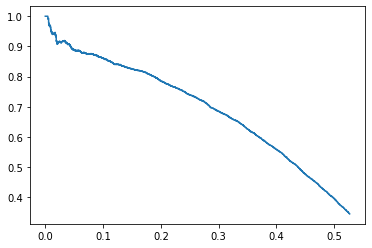

In [ ]:
import matplotlib.pyplot as plt
plt.plot(recall,precision)
